In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker


import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

In [2]:
!pwd

/home/hyejin/Desktop/my_git/Hubbard_NN/2_nn


Text(0.5, 0.55, '$\\omega\\simeq0$')

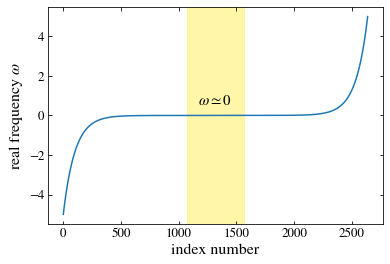

In [3]:
D = 1
out_node = 2
directory = '../1_dmftsolver/NRG'

w, _,_,_,_,_,_,_,_,_ = np.loadtxt(f'{directory}/B_14_beta10000/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')
plt.plot(w.real)
plt.ylabel(r'real frequency $\omega$')
plt.xlabel('index number')
plt.axvspan(1319-250, 1319+250, alpha=0.5, color='#ffee52')
plt.annotate(r'$\omega\simeq0$', xy=(0.5, 0.55), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.savefig('index2w.png')

# Neural network

In [4]:
class Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

# Data

In [5]:
beta = 10000
U_c1_4, U_c2_4 = 2.25, 2.9
    
w_len = len(np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{2.000:.3f}.dat', \
                       unpack = True, dtype = 'complex128')[0])

up_num = 138
dn_num = 129

U = np.array([0.001*i for i in range(500, 5001)])
U1_4 = np.zeros(up_num, dtype = 'float64')
U2_4 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_4[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_4[n] = u
    n += 1
    
x_test_4 = np.zeros((len(U1_4)+len(U2_4), 2638), dtype = 'float64')
UU1 = U1_4[U1_4<U_c1_4]
UU2 = U2_4[U2_4>U_c2_4]
x = np.zeros((len(UU1)+len(UU2), 2638), dtype = 'float64')

# train data
for i, u in enumerate(UU1):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x[i] = ((D/2)**2*G_r)
for i, u in enumerate(UU2):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x[i+len(UU1)] = ((D/2)**2*G_r)
x = torch.FloatTensor(x)
size = len(x[0])

# test data
for i, u in enumerate(U1_4):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4[i] = ((D/2)**2*G_r)
for i, u in enumerate(U2_4):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_4[i+len(U1_4)] = ((D/2)**2*G_r)
x_test_4 = torch.FloatTensor(x_test_4)


# Metal = 1, Insulator = 0
y_temp1 = np.array(UU1 <= U_c2_4)
y_temp2 = np.array(UU2 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)

y_temp1 = np.array(U1_4 <= U_c2_4)
y_temp2 = np.array(U2_4 < U_c1_4)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_4 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_4 = torch.FloatTensor(y_test_4)
UU_4 = np.concatenate((U1_4, U2_4))

def divide(x_, y_):
    mask = np.random.rand(len(x_)) < 0.8  # train : val = 4 : 1
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = divide(x, y)

In [6]:
beta=1000
U_c1_3, U_c2_3 = 2.225, 2.69

up_num = 50
dn_num = 60

U1_3 = np.zeros(up_num, dtype = 'float64')
U2_3 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_3[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_3[n] = u
    n += 1
    
x_test_3 = np.zeros((len(U1_3)+len(U2_3), 2638), dtype = 'float64')
UU1 = U1_3[U1_3<U_c1_3]
UU2 = U2_3[U2_3>U_c2_3]

# test data
for i, u in enumerate(U1_3):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_3[i] = ((D/2)**2*G_r)
for i, u in enumerate(U2_3):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_3[i+len(U1_3)] = ((D/2)**2*G_r)
x_test_3 = torch.FloatTensor(x_test_3)
y_temp1 = np.array(U1_3 <= U_c2_3)
y_temp2 = np.array(U2_3 < U_c1_3)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_3 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_3 = torch.FloatTensor(y_test_3)
UU_3 = np.concatenate((U1_3, U2_3))

In [7]:
beta=100
U_c1_2, U_c2_2 = 2.22, 2.5

up_num = 31
dn_num = 64

U1_2 = np.zeros(up_num, dtype = 'float64')
U2_2 = np.zeros(dn_num, dtype = 'float64')

n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U1_2[n] = u
    n += 1
    
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    U2_2[n] = u
    n += 1
    
x_test_2 = np.zeros((len(U1_2)+len(U2_2), 2638), dtype = 'float64')
UU1 = U1_2[U1_2<U_c1_2]
UU2 = U2_2[U2_2>U_c2_2]

# test data
for i, u in enumerate(U1_2):
    if path.isfile(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_14_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_2[i] = ((D/2)**2*G_r)
for i, u in enumerate(U2_2):
    if path.isfile(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat')==False: continue
    w, A, G_r, G_i, S_r, S_i, Xn_r, Xn_i, Xs_r, Xs_i = np.loadtxt(f'{directory}/B_41_beta{beta:d}/Bethe-{u:.3f}.dat', \
                                                                 unpack=True, dtype = 'float64')
    x_test_2[i+len(U1_2)] = ((D/2)**2*G_r)
x_test_2 = torch.FloatTensor(x_test_2)

y_temp1 = np.array(U1_2 <= U_c2_2)
y_temp2 = np.array(U2_2 < U_c1_2)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_2 = np.stack([y_temp, ~y_temp], axis = 1)
y_test_2 = torch.FloatTensor(y_test_2)
UU_2 = np.concatenate((U1_2, U2_2))

# Training

In [39]:
learning_rate = 1e-3
reg = 1e-3
h_node = 100
func = nn.ReLU # activation function
model = Net(node = h_node, activate = func)

# Begin training and validation
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
n_epochs = 100
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss1(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_test_4), y_test_4)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.6f, valid loss = %.6f, accuracy = %.8f' \
                %(epoch, loss.item(), valid_loss, t_acc))

epoch = 0, training loss = 6.521917, valid loss = 6.352816, accuracy = 1.00000000
epoch = 10, training loss = 6.094980, valid loss = 6.107945, accuracy = 1.00000000
epoch = 20, training loss = 6.305640, valid loss = 6.326559, accuracy = 1.00000000
epoch = 30, training loss = 6.499576, valid loss = 6.514852, accuracy = 1.00000000
epoch = 40, training loss = 6.633026, valid loss = 6.643300, accuracy = 1.00000000
epoch = 50, training loss = 6.723525, valid loss = 6.730630, accuracy = 1.00000000
epoch = 60, training loss = 6.789473, valid loss = 6.794976, accuracy = 0.99812734
epoch = 70, training loss = 6.842239, valid loss = 6.846845, accuracy = 0.99625468
epoch = 80, training loss = 6.887761, valid loss = 6.891859, accuracy = 0.99625468
epoch = 90, training loss = 6.928850, valid loss = 6.932622, accuracy = 0.99625468
epoch = 100, training loss = 6.966868, valid loss = 6.970389, accuracy = 0.99625468


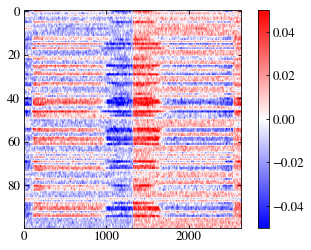

In [40]:
op = {'vmin': -0.05, 'vmax': 0.05}
im1 = plt.imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='bwr', **op)
cd = plt.colorbar(im1)
plt.show()
#im2 = plt.imshow(np.array(model.W2.weight.data).T, aspect=15/h_node, cmap='bwr')


epoch = 100, training loss = 6.96686792, accuracy = 0.99625468


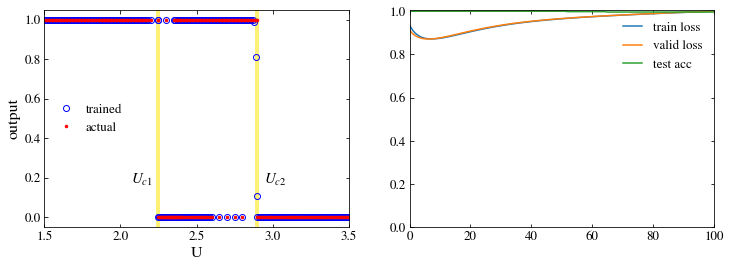

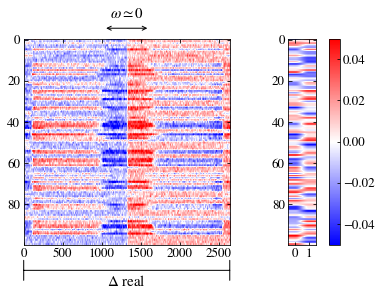

In [41]:
print('epoch = %d, training loss = %.8f, accuracy = %.8f' \
                  %(epoch, loss.item(), model.accuracy(model.forward(x_test_4), y_test_4)))
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].axvline(U_c1_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].axvline(U_c2_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].plot(UU_4, model.forward(x_test_4).data[:,0], 'bo', mfc='none', label = 'trained')
#ax[0].plot(UU_4, -x_test_4[:,1319]/torch.max(-x_test_4[:, 1319]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
ax[0].plot(UU_4, y_test_4[:,0], 'r.', ms = 5, label = 'actual')
ax[0].set_xlim(1.5, 3.5)
ax[0].set_ylabel('output')
ax[0].set_xlabel('U')
ax[0].annotate(r'$U_{c1}$', xy=(0.32, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].annotate(r'$U_{c2}$', xy=(0.76, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].legend(loc='center left')

ax[1].plot(np.arange(len(train_loss)), train_loss/np.max(train_loss), '-', label='train loss')
ax[1].plot(np.arange(len(val_loss)), val_loss/np.max(train_loss), '-', label='valid loss')
ax[1].plot(np.arange(len(test_acc)), test_acc, '-', label='test acc')
ax[1].set_xlim(0, epoch)
ax[1].set_ylim(0)
ax[1].legend()
plt.show()

import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
op = {'vmin': -0.05, 'vmax': 0.05}
im1 = ax[0].imshow(np.array(model.W1.weight.data), aspect=size/h_node, cmap='bwr', **op)
im2 = ax[1].imshow(np.array(model.W2.weight.data).T, aspect=15/h_node, cmap='bwr')

cd = plt.colorbar(im1, ax = ax[1])
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(500))
pos = ax[1].get_position()
ax[1].set_position([pos.x0+0.35, pos.y0, pos.width, pos.height])

ax[0].annotate('', xy=(0, -0.125), xytext=(1, -0.125), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0})

ax[0].annotate('', xy=(0.4, 1.05), xytext=(0.6, 1.05), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
ax[0].annotate(r'$\omega\simeq0$', xy=(0.5, 1.1), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].annotate(r'$\Delta$ real', xy=(0.5, -0.2), xycoords = 'axes fraction', fontsize=15, ha='center')

fig.tight_layout()
plt.savefig(f'Weight_L1_{h_node}_real.png')


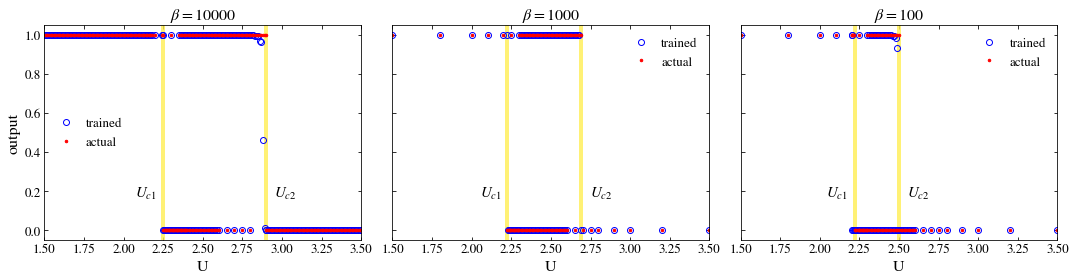

In [21]:
fig, ax = plt.subplots(1,3, figsize=(15, 4), sharey=True)


ax[0].axvline(U_c1_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].axvline(U_c2_4, c = '#ffee52', lw = '4',  alpha=0.8)
ax[0].plot(UU_4, model.forward(x_test_4).data[:,0], 'bo', mfc='none', label = 'trained')
ax[0].plot(UU_4, y_test_4[:,0], 'r.', ms = 5, label = 'actual')
ax[0].set_xlim(1.5, 3.5)
ax[0].set_ylabel('output')
ax[0].set_xlabel('U')
ax[0].annotate(r'$U_{c1}$', xy=(0.32, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].annotate(r'$U_{c2}$', xy=(0.76, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[0].set_title(r'$\beta=10000$', fontsize=16)
ax[0].legend(loc='center left')

ax[1].axvline(U_c1_3, c = '#ffee52', lw = '4',  alpha=0.8)
ax[1].axvline(U_c2_3, c = '#ffee52', lw = '4',  alpha=0.8)
ax[1].plot(UU_3, model.forward(x_test_3).data[:,0], 'bo', mfc='none', label = 'trained')
ax[1].plot(UU_3, y_test_3[:,0], 'r.', ms = 5, label = 'actual')
ax[1].set_xlim(1.5, 3.5)
ax[1].set_xlabel('U')
ax[1].annotate(r'$U_{c1}$', xy=(0.31, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[1].annotate(r'$U_{c2}$', xy=(0.66, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[1].set_title(r'$\beta=1000$', fontsize=16)
ax[1].legend()

ax[2].axvline(U_c1_2, c = '#ffee52', lw = '4',  alpha=0.8)
ax[2].axvline(U_c2_2, c = '#ffee52', lw = '4',  alpha=0.8)
ax[2].plot(UU_2, model.forward(x_test_2).data[:,0], 'bo', mfc='none', label = 'trained')
ax[2].plot(UU_2, y_test_2[:,0], 'r.', ms = 5, label = 'actual')
ax[2].set_xlim(1.5, 3.5)
ax[2].set_xlabel('U')
ax[2].annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[2].annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
ax[2].set_title(r'$\beta=100$', fontsize=16)
ax[2].legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('output_real.png')